# Dataset name / short description:

Motorcycle dataset
This dataset contains information about used motorcycles. Last update (same as publish year?) in 2020. Dataset was made by webscraping.
This data can be used for a lot of purposes such as price prediction to exemplify the use of linear regression in Machine Learning.

# Data source (url):

https://www.kaggle.com/datasets/nehalbirla/motorcycle-dataset?resource=download

# Data format:

Dataset is originally a .csv file

# Data description and limitations:

| Feature | Type | Description |
|----------|----------|----------|
| name   | str   | Name of the motorcycle   |
| selling price   | int   | Price at which seller is selling the motorcycle   |
| year   | int   | Year in which bike was bought   |
| seller type   | str, categorical (binary)   | Tells if a Seller is Individual or a Dealer   |
| owner   | str   | Number of previous owners of the vehicle.   |
| km driven   | int   | Number of kilometre motorcycle has traveled   |
| ex showroom price   | int   | Showroom price of the motorcycle   |

Limitations:
1. We only have one thousand rows
2. Almost half of the values in ex_showroom_price is missing, which might be hard to deal with
3. We don't have any information about technical characteristics of the motorcycles.
4. We don't have any information about motorcycle condition
5. Name column also includes name of manufacturer. It is possible to extract and then target encode for further ML uses, but it might be quite hard.


# Code: importing modules, custom functions and loading the data

In [5]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt
# Load data
df = pd.read_csv("BIKE DETAILS.csv")


# Code: Data clean-up procedure


In [7]:
# First of all let's deal with strings and convert them to integers
# Replace strings with numbers
seller_types = {"Individual" : 1,
                "Dealer" : 2}
df["seller_type"] = df.seller_type.replace(seller_types)

# Keep only numbers from owner column
df["owner"] = df["owner"].str.extract(r'(\d+)').astype(int)

C:\Users\kiril\AppData\Local\Temp\ipykernel_8896\665077774.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["seller_type"] = df.seller_type.replace(seller_types)


In [8]:
# It is possible to extract manufacturer from the name of the bike

unique_names = df.name.unique()
# Common two-word brands
two_word_brands = ['Royal Enfield', 'Hero Honda']

def extract_manufacturer(name):
    # Check two-word brands first
    for brand in two_word_brands:
        if name.startswith(brand):
            return brand
    # Otherwise, first word
    return name.split()[0]

# Create dictionary
manufacturer_dict = {name: extract_manufacturer(name) for name in unique_names}

# Create new column with only manufacturer name
df["manufacturer"] = df["name"].replace(manufacturer_dict)
# Drop the full name
df = df.drop(columns="name")

In [9]:
# Check how many manufacturers there are
len(df.manufacturer.unique())

21

In [10]:
# Now, we can change the manufacturer name to target encoded number 
# (mean selling price for each manufacturer)
target_mean = round(df.groupby("manufacturer")["selling_price"].mean(), 1)

# We will keep the string version for now, because it is easier to understand visualizations when it's written in human language
df["manufacturer_encoded"] = df["manufacturer"].map(target_mean)

In [11]:
# Let's deal with missing values in ex_showroom_price
print(f"Missing values: {df.ex_showroom_price.isna().sum()}")
print(f"Total rows: {len(df)}")

Missing values: 435
Total rows: 1061


In [12]:
# 40% would be too painfull to delete
# What we could do is try to impute missing value with "smart" model based imputation
# It is possible to use already existing automatic imputers
# Or even make a custom model that would predict missing values based on other parameters
# e.g. XGBoost predicting missing values based on price and year

# Keep the track whether or not value was imputed:
df["Imputed"] = df["ex_showroom_price"].isna()

imputer = KNNImputer(n_neighbors=2)
# Select numeric columns
numeric_cols = df.select_dtypes(include="number").columns
# Fit and transform 
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])


In [13]:
#  Finally, drop the duplacites if any and review what we got
df = df.drop_duplicates()
df

,selling_price,year,seller_type,owner,km_driven,ex_showroom_price,manufacturer,manufacturer_encoded,Imputed
0,175000.0,2019.0,1.0,1.0,350.0,169057.0,Royal Enfield,128549.5,True
1,45000.0,2017.0,1.0,1.0,5650.0,58313.0,Honda,44916.0,True
2,150000.0,2018.0,1.0,1.0,12000.0,148114.0,Royal Enfield,128549.5,False
3,65000.0,2015.0,1.0,1.0,23000.0,89643.0,Yamaha,63656.9,False
4,20000.0,2011.0,1.0,2.0,21000.0,49373.0,Yamaha,63656.9,True
...,...,...,...,...,...,...,...,...,...
1056,17000.0,2010.0,1.0,1.0,500000.0,52000.0,Activa,34000.0,False
1057,16000.0,2012.0,1.0,1.0,33000.0,51000.0,Honda,44916.0,False
1058,15000.0,2013.0,1.0,2.0,35000.0,57000.0,Bajaj,44990.4,False
1059,12000.0,2009.0,1.0,1.0,53000.0,58000.0,Honda,44916.0,False


# Code: Data analysis

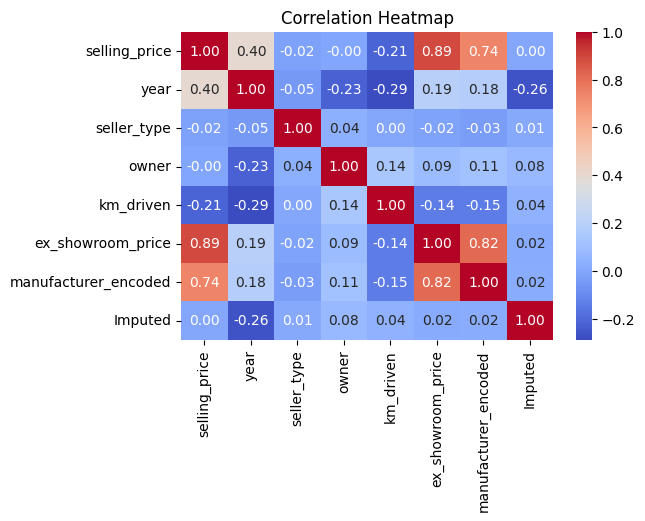

In [14]:
# Compute correlation matrix
corr = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Insights from correlations:
1. As expected, selling price is highly dependent on showroom price (buying price). This is quite selfexplanatory
2. Other biggest factors that are affecting selling price are year and kilometers. These are the only features that can give us idea about bikes condition
3. Column seller type is quite usuless, because 99% of the values are 1 (individual seller)
4. Owner amount correlating by nature with year and kilometers. Basically this is three dimensions of the thing, we can answer the question "How old is this bike" with each of them (10 year, 100k kilometers, 7 owners). However I think there might be dominating class (1st owner) which makes correlation look smaller than it is.

c:\Users\kiril\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\kiril\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\kiril\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\relational.py:441: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to

<AxesSubplot: xlabel='year', ylabel='selling_price'>

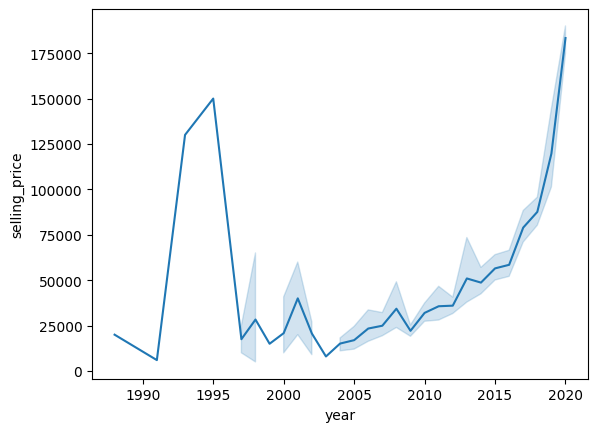

In [15]:
# Selling price by year
sns.lineplot(x=df.year, y=df.selling_price)

Otherwise looks normal, by looks like some of old bikes are rare and in good condition.

In [16]:
df[(df.year < 1999) & (df.year > 1990)]

,selling_price,year,seller_type,owner,km_driven,ex_showroom_price,manufacturer,manufacturer_encoded,Imputed
363,10000.0,1997.0,1.0,1.0,646000.0,51133.5,Hero Honda,24525.0,True
543,5000.0,1998.0,1.0,1.0,60000.0,52559.5,TVS,46374.0,True
554,65000.0,1998.0,1.0,3.0,16500.0,100984.0,Yamaha,63656.9,True
567,6000.0,1991.0,1.0,1.0,35000.0,53633.5,Bajaj,44990.4,True
571,15000.0,1998.0,1.0,1.0,65000.0,56300.0,Hero Honda,24525.0,True
715,25000.0,1997.0,1.0,1.0,45354.0,78712.0,Yamaha,63656.9,True
861,130000.0,1993.0,1.0,2.0,10000.0,149057.0,Royal Enfield,128549.5,True
868,150000.0,1995.0,1.0,3.0,20000.0,164779.5,Royal Enfield,128549.5,True


Exactly, there are two Royal Enfields from 1993 and 1995 with only 10k and 20k kilometers driven.

<AxesSubplot: xlabel='km_driven', ylabel='selling_price'>

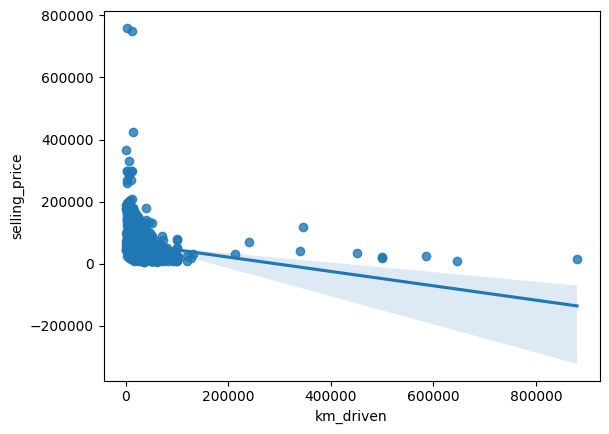

In [17]:
sns.regplot(x=df.km_driven, y=df.selling_price)

I've expected more clear relationships between kilometers and selling price, but I guess in motorcycle world kilometers are more limited than in the car world. Also this might be a problem of this dataset - it might miss data about such motorcycles.

But will it be clearer if we don't take into account these "outliers"?

<AxesSubplot: xlabel='km_driven', ylabel='selling_price'>

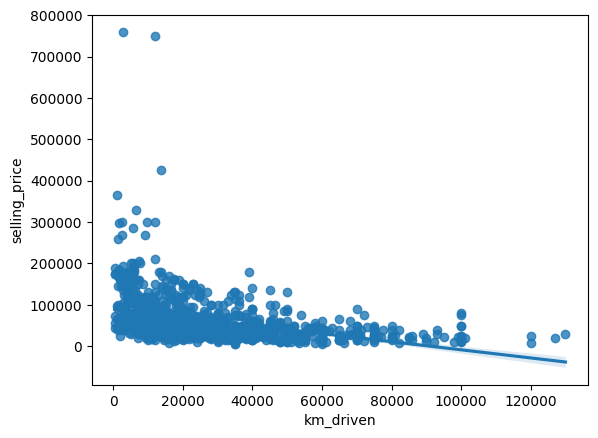

In [18]:
sns.regplot(x=df.km_driven[df.km_driven < 200000], y=df.selling_price[df.km_driven < 200000])

Now it is little bit better, we can clearly see that bikes with less than 20k kilometers have overall better selling price, but after some point kilometers are loosing their significancy.

Now let's check amount of owners

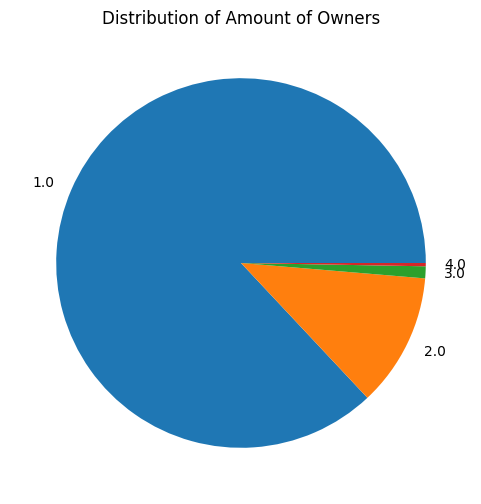

In [19]:
counts = df.owner.value_counts()
plt.figure(figsize=(6,6))
plt.pie(counts, labels=counts.index)
plt.title("Distribution of Amount of Owners")
plt.show()

As I thought there is a dominating class. There are less than 5 rows with 4+ onwers and around 10 are 3 owners. And their average price won't tell us anything usefull. I think we should join 2, 3 and 4 owners into the same bin.

In [20]:
df["owner"] = df["owner"].replace({3:2, 4:2})

<AxesSubplot: xlabel='owner', ylabel='selling_price'>

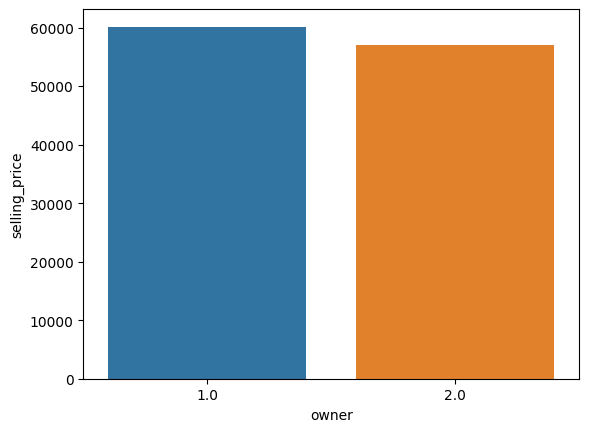

In [21]:
sns.barplot(
    data=df,
    x="owner",
    y="selling_price",
    errorbar=None
)


Better but still not satisfied, I think the best solution could be:
a) get more data with 2-3-4 owners
b) create a bike category column, something like [normal, sport, premium, super rare]

It seems to me that amount of owners is very subjective and in different categories can affect price in different ways: 
- If you are buying bike for every day use - amount of owners should be as low as possible. It is easier to get an idea of how single owner was treating the bike and there shouldn't be as much problems as with 4 owners
- But if you are buying some kind of super rare bike to put in museum - you are not anymore thinking about how many owners it had.

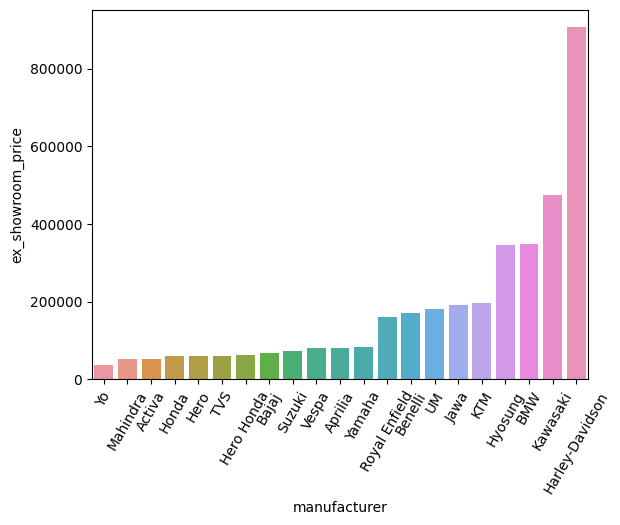

In [22]:
# Group by manufacturer, count and sort by average
order = (
    df.groupby("manufacturer")["ex_showroom_price"]
    .median()
    .sort_values()
    .index
)

sns.barplot(
    data=df,
    x="manufacturer",
    y="ex_showroom_price",
    errorbar=None,
    order=order, estimator=np.median
)
plt.xticks(rotation=60)
plt.show()

<AxesSubplot: xlabel='manufacturer'>

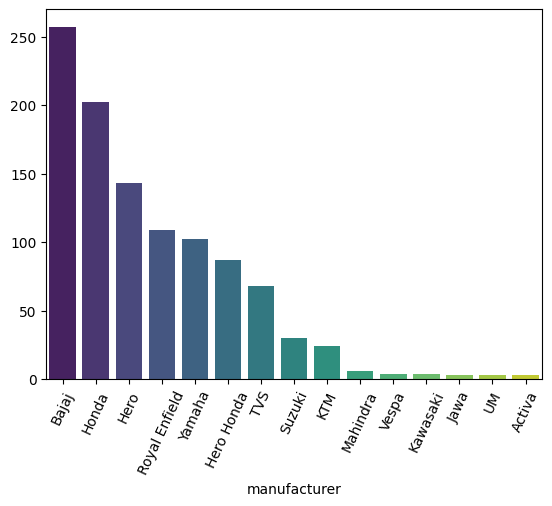

In [61]:
top10_manufacturers = df['manufacturer'].value_counts().nlargest(15)

plt.xticks(rotation=65)
sns.barplot(x=top10_manufacturers.index, y=top10_manufacturers.values, palette="viridis")

And again we lack a lot of data on different manufacturers. I think that if get more data, then we will get rid of such explosive spikes, but situation in general won't change. There are manufacturers that are making "legendary" vehicles, there are some that are prioritizing quality, some who aims volume and etc. And their prices will change accordingly.

<AxesSubplot: xlabel='selling_price', ylabel='ex_showroom_price'>

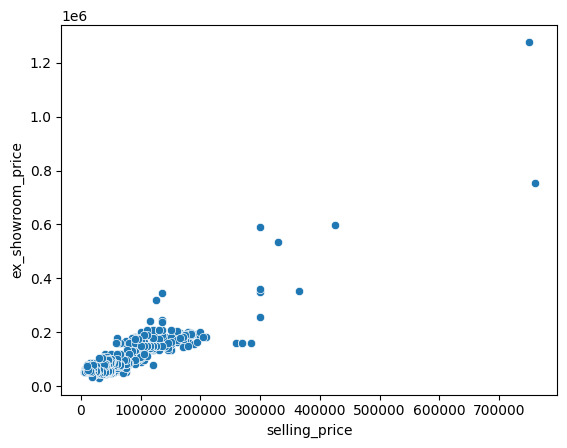

In [24]:
sns.scatterplot(x=df.selling_price, y=df.ex_showroom_price)

Came to my mind, that there are possibly bikes that are now more expensive than back then when they were first time sold. Let's check that. I think it would be right to exclude imputed values

In [25]:
df_profit = df[(df.selling_price > df.ex_showroom_price) & (df.Imputed == False)]
df_profit

,selling_price,year,seller_type,owner,km_driven,ex_showroom_price,manufacturer,manufacturer_encoded,Imputed
2,150000.0,2018.0,1.0,1.0,12000.0,148114.0,Royal Enfield,128549.5,False
13,365000.0,2019.0,1.0,1.0,1127.0,351680.0,Yamaha,63656.9,False
18,150000.0,2018.0,1.0,1.0,23000.0,148114.0,Royal Enfield,128549.5,False
35,60000.0,2018.0,1.0,1.0,6502.0,57557.0,Honda,44916.0,False
44,85000.0,2018.0,1.0,1.0,8000.0,84042.0,Yamaha,63656.9,False
48,60000.0,2018.0,1.0,1.0,13000.0,59844.0,Yamaha,63656.9,False
54,70000.0,2019.0,1.0,1.0,3000.0,59422.0,Honda,44916.0,False
74,165000.0,2019.0,1.0,1.0,3700.0,164004.0,Royal Enfield,128549.5,False
82,62000.0,2019.0,1.0,1.0,3500.0,57557.0,Honda,44916.0,False
96,150000.0,2019.0,1.0,1.0,2500.0,133680.0,Yamaha,63656.9,False


In [28]:
df_profit["price_difference"] = df_profit["selling_price"] - df_profit["ex_showroom_price"]


C:\Users\kiril\AppData\Local\Temp\ipykernel_8896\2218412817.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_profit["price_difference"] = df_profit["selling_price"] - df_profit["ex_showroom_price"]


In [29]:
df_profit["price_difference"].describe()

count       41.00000
mean      8464.02439
std       9292.85255
min        156.00000
25%       1886.00000
50%       4443.00000
75%      11888.00000
max      34260.00000
Name: price_difference, dtype: float64

In [ ]:
# Check real buying value of the case with biggest difference in price
df_profit[df_profit.price_difference == 34260]

,selling_price,year,seller_type,owner,km_driven,ex_showroom_price,manufacturer,manufacturer_encoded,Imputed,price_difference
136,190000.0,2020.0,1.0,1.0,500.0,155740.0,Royal Enfield,128549.5,False,34260.0


Despite the fact that some bikes cost more nowadays than their original price, none of the owners probably got any real value from it, as the inflation last years was quite big

https://www.bls.gov/data/inflation_calculator.htm

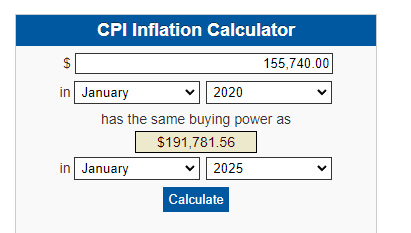

Let's see now how years are distributed:

<AxesSubplot: xlabel='year'>

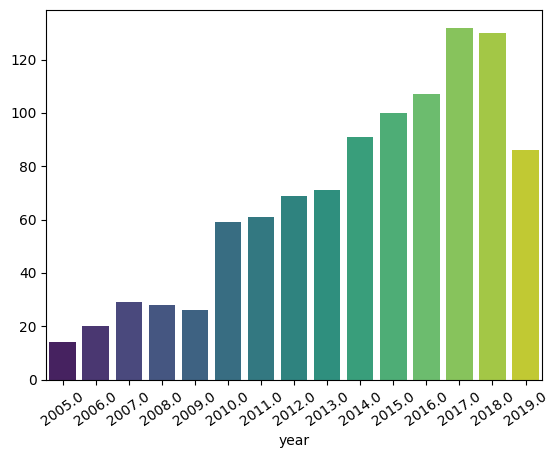

In [62]:
top15_years = df['year'].value_counts().nlargest(15)

plt.xticks(rotation=35)
sns.barplot(x=top15_years.index, y=top15_years.values, palette="viridis")

So the majority of the bikes are made in last 5 years (if dataset was scraped in 2020)

In [65]:
df

,selling_price,year,seller_type,owner,km_driven,ex_showroom_price,manufacturer,manufacturer_encoded,Imputed
0,175000.0,2019.0,1.0,1.0,350.0,169057.0,Royal Enfield,128549.5,True
1,45000.0,2017.0,1.0,1.0,5650.0,58313.0,Honda,44916.0,True
2,150000.0,2018.0,1.0,1.0,12000.0,148114.0,Royal Enfield,128549.5,False
3,65000.0,2015.0,1.0,1.0,23000.0,89643.0,Yamaha,63656.9,False
4,20000.0,2011.0,1.0,2.0,21000.0,49373.0,Yamaha,63656.9,True
...,...,...,...,...,...,...,...,...,...
1056,17000.0,2010.0,1.0,1.0,500000.0,52000.0,Activa,34000.0,False
1057,16000.0,2012.0,1.0,1.0,33000.0,51000.0,Honda,44916.0,False
1058,15000.0,2013.0,1.0,2.0,35000.0,57000.0,Bajaj,44990.4,False
1059,12000.0,2009.0,1.0,1.0,53000.0,58000.0,Honda,44916.0,False


# Results and summary:

Selling price is more or less affected by all dimensions of the condition: mileage, age and even amount of owners. Usually, price goes down when any of these parameters rises.However, as we are in motorcycle domain, there are a lot exceptions, such as very rare old vehicles or classical motorcycles that people are willing to pay more.

Another factor affecting the price is manufacturer (or class of the vehicle would be more correct term?). Some of them are producing bulk bikes, some focus on classic and others on luxury or sport. Every category would have its own price fork. 

The main factor highly correlating with selling price is vehicles previous showroom price, which is self explanatory and natural.

There are some cases, when current price is more than previous one, but it is hard to say that anyone gets actual profit from such deals as it barely covers the inflation. Another thing related to this is that selling price is the price owner **asking** and probably in the most cases actual selling price would be lower.

Most of the data comes from 2010-2019 and the most "popular" manufacturers are Bajaj, Honda, Hero, TVS, Yamaha. All of these are quite big manufacturers and could be classified as mass-market production, some of them are a little bit sportier but in general these are "usual" bikes with lower price. Surprising is that Royal Enfield is also on the list, as this company is more niche and produces Premium cruisers / retro bikes.

Also now I'm thinking that there is one addition to limitations of the dataset: we don't know what are the websites where the data was scraped. For example, Bajaj is almost not present in US or EU market, so it has to be parsed from some Asian website. Same goes for EU and US brands. So can we now be sure that the currency is the same and we don't mix euros, dollars and rupees?

# Ideas for further improvements:

1. Gather more data from dealers
2. Add source of the data while scraping - helps to verify data and understand distribution
3. Add geographical information - which market and what region to find some relations 
4. Might be impossible to get, but getting actual selling price after the deal is closed would be quite interesting. It is then possible to compare with asked price and geography, for instance.
5. Classify manufacturers or even certain bike models into categories. E.g. mass-market, sport eco, sport premium, classic, luxury and so on. 